参考：https://blog.csdn.net/dgvv4/article/details/124379152
使用循环神经网络 LSTM 完成有多个特征的气温预测

### 导入工具包
这里使用GPU加速计算，加快网络的训练速度

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 获取数据

In [2]:
#（1）获取数据，按时间间隔1h记录的电力数据
filepath = 'test_data\climate.csv'
data = pd.read_csv(filepath)
print(data.head())

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

In [3]:
#（2）特征选择
# 选择从第1列开始往后的所有行的数据
feat = data.iloc[:, 1:11]  # 最后4个特征列不要
date = data.iloc[:, 0]   # 获取时间信息

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000182DC48DD60>,
      dtype=object)

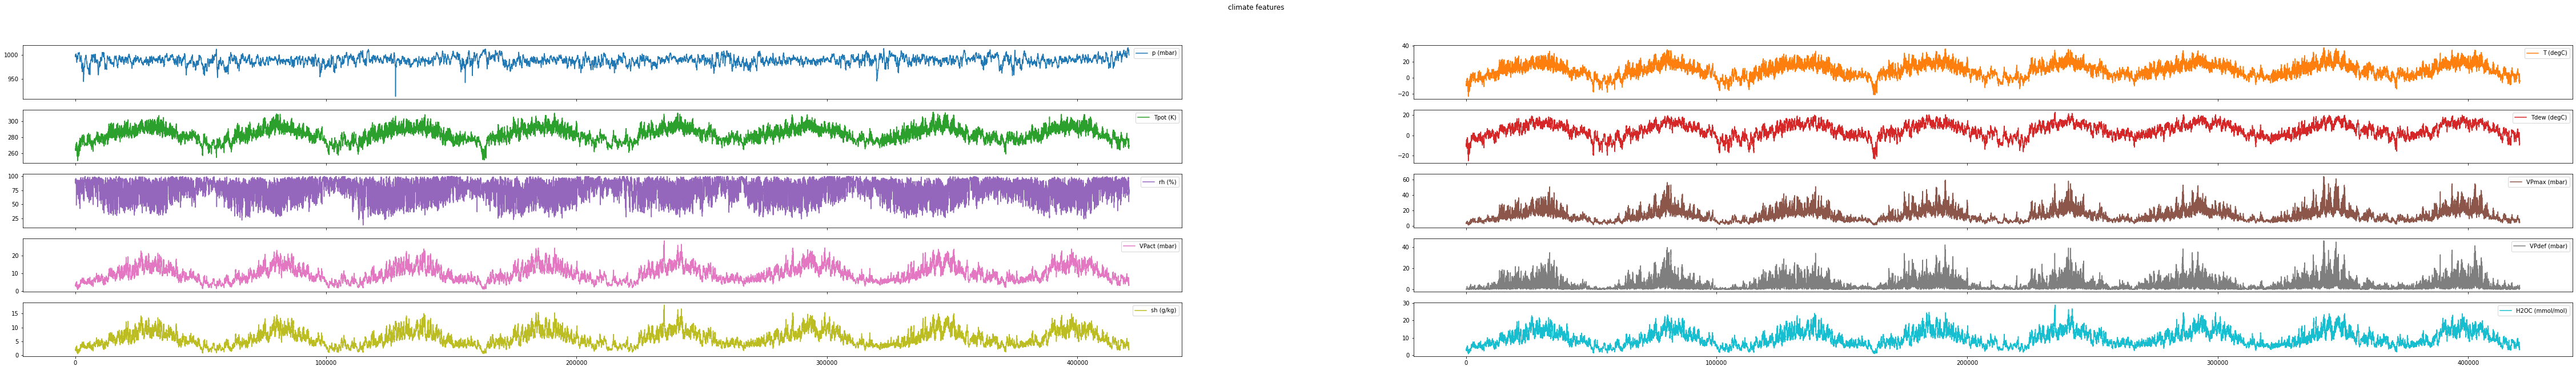

In [4]:
#（3）利用pandas绘图展示每个特征点分布情况
feat.plot(subplots=True, figsize=(80,10),  # 为每一列单独开辟子图，设置画板大小
          layout=(5,2), title='climate features')  # 14张图的排序方式，设置标题

### 数据预处理

In [7]:
#（4）特征数据预处理
train_num = 20000  # 取前2w组数据用于训练
val_num = 23000  # 取2w-2.3w的数据用于验证
# 2.3w-2.5w的数据用于验证用于测试
 
# 求训练集的每个特征列的均值和标准差
feat_mean = feat[:train_num].mean(axis=0)
feat_std = feat[:train_num].std(axis=0)
 
# 对整个数据集计算标准差
feat = (feat - feat_mean) / feat_std
 
# 保存所有的气温数据，即标签数据
targets = feat.iloc[:,1]   # 取标准化之后的气温数据作为标签值

### 时间序列函数提取特征和标签
通过一个滑动窗口在数据集上移动，例如使用当前10个特征的20行数据预测未来某一时间点/段的气温。任务要求使用连续5天的数据预测下一个时间点的气温值，数据是10min记录一次的。

对某一时间点的预测：五天一共有5*24*6=720个数据，窗口每次滑动一步，第一次滑动窗口范围 range(0, 720, 1)，预测第720个气温。第二次滑动窗口范围 range(1,721,1)，预测第721个气温。range()取值顾头不顾尾

对某一时间段的预测：由于数据集是10min记录一次的，两两数据行之间的差别很小，可以设置一个步长每隔60min取一次特征数据，第一次滑动窗口范围 range(0, 720, 6)，预测下一整天的每个小时的气温数据，即 range(720, 720+24*6, 6)。第二次滑动窗口范围 range(1,721,6)，预测下一天的小时气温 range(721, 721+24*6, 6)

In [8]:
'''
dataset 代表特征数据
start_index 代表从数据的第几个索引值开始取
history_size 滑动窗口大小
end_index 代表数据取到哪个索引就结束
target_size 代表预测未来某一时间点还是时间段的气温。例如target_size=0代表用前20个特征预测第21个的气温
step 代表在滑动窗口中每隔多少步取一组特征
point_time 布尔类型，用来表示预测未来某一时间点的气温，还是时间段的气温
true 原始气温数据的所有标签值
'''
 
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值
    
    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]
    
    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size
        
    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):
        
        # 滑窗中的值不全部取出来用，每隔60min取一次
        index = range(i-history_size, i, step)  # 第一次相当于range(0, start_index, 6)
        
        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i+target_size])
        
        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i+target_size])
    
    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)

### 划分数据集

In [9]:
#（6）划分数据集
history_size = 5*24*6  # 每个滑窗取5天的数据量=720
target_size =  0  # 预测未来下一个时间点的气温值
step = 1  # 步长为1取所有的行
 
# 构造训练集
x_train, y_train = TimeSeries(dataset=feat, start_index=0, history_size=history_size, end_index=train_num,
                              step=step, target_size=target_size, point_time=True, true=targets)
 
# 构造验证集
x_val, y_val = TimeSeries(dataset=feat, start_index=train_num, history_size=history_size, end_index=val_num,
                          step=step, target_size=target_size, point_time=True, true=targets)
 
# 构造测试集
x_test, y_test =  TimeSeries(dataset=feat, start_index=val_num, history_size=history_size, end_index=25000,
                              step=step, target_size=target_size, point_time=True, true=targets)
 
# 查看数据集信息
print('x_train_shape:', x_train.shape)  # (19280, 720, 10)
print('y_train_shape:', y_train.shape)  # (19280,)

x_train_shape: (19280, 720, 10)
y_train_shape: (19280,)


### 构造数据集
将划分好了的特征值和标签值转为tensor类型，对训练集的特征行随机打乱shuffle()，并且每次迭代时每个step训练batchsize=128组数据。设置迭代器 iter()，从数据集中取出一个batch的数据 next()。标签值y_train代表滑动窗口的每720行特征数据对应1个标签气温值

In [11]:
#（7）构造数据集
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))  # 训练集
train_ds = train_ds.batch(128).shuffle(10000)  # 随机打乱、每个step处理128组数据
 
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))  # 验证集
val_ds = val_ds.batch(128)  
 
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))  # 测试集
test_ds = test_ds.batch(128)  
 
# 查看数据集信息
sample = next(iter(train_ds))  # 取出一个batch的数据
print('x_train.shape:', sample[0].shape)  # [128, 720, 10]
print('y_train.shape:', sample[1].shape)  # [128, ]

x_train.shape: (128, 720, 10)
y_train.shape: (128,)


### 模型构建
接下来就是自定义LSTM网络，这个无所谓想怎么搭都行，要注意的时 layers.LSTM() 层中有一个参数 return_sequences，代表返回输出序列中的最后一个值，还是所有值。默认False。一般是下一层还是 LSTM 的时候才用 return_sequences=True

In [12]:
#（8）模型构建
inputs_shape = sample[0].shape[1:]  # [120,10]  不需要写batch的维度大小
inputs = keras.Input(shape=inputs_shape)  # 输入层
 
# LSTM层，设置l2正则化
x = layers.LSTM(units=8, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = layers.LeakyReLU()(x)
x = layers.LSTM(units=16, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = layers.LeakyReLU()(x)
x = layers.LSTM(units=32, dropout=0.5, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.LeakyReLU()(x)
# 全连接层，随即正态分布的权重初始化，l2正则化
x = layers.Dense(64,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
# 输出层返回回归计算后的未来某一时间点的气温值
outputs = layers.Dense(1)(x)  # 标签shape要和网络shape一样
 
# 构建模型
model = keras.Model(inputs, outputs)
 
# 查看网络结构
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 10)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 720, 16)           1728      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 720, 16)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                6272      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0     

### 网络训练
首先进行模型编译，使用adam优化器设置学习率0.01，使用平均绝对误差作为网络训练时的损失函数，网络迭代20次。回归问题不能设置metrics监控指标为准确率，这一般用于分类问题。

In [13]:
# 网络编译
model.compile(optimizer = keras.optimizers.Adam(0.001),  # adam优化器学习率0.001
              loss = tf.keras.losses.MeanAbsoluteError())  # 计算标签和预测之间绝对差异的平均值
                          
epochs = 15  # 网络迭代次数
 
# 网络训练
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
 
# 测试集评价
model.evaluate(test_ds)  # loss: 0.1212

Epoch 1/15
151/151 [==============================] - 67s 425ms/step - loss: 0.6601 - val_loss: 0.4463
Epoch 2/15
151/151 [==============================] - 66s 436ms/step - loss: 0.3913 - val_loss: 0.2893
Epoch 3/15
151/151 [==============================] - 66s 437ms/step - loss: 0.3137 - val_loss: 0.2513
Epoch 4/15
151/151 [==============================] - 65s 432ms/step - loss: 0.2758 - val_loss: 0.1972
Epoch 5/15
151/151 [==============================] - 67s 441ms/step - loss: 0.2479 - val_loss: 0.2368
Epoch 6/15
151/151 [==============================] - 67s 442ms/step - loss: 0.2300 - val_loss: 0.1662
Epoch 7/15
151/151 [==============================] - 67s 444ms/step - loss: 0.2272 - val_loss: 0.3988
Epoch 8/15
151/151 [==============================] - 67s 444ms/step - loss: 0.2235 - val_loss: 0.1459
Epoch 9/15
151/151 [==============================] - 69s 456ms/step - loss: 0.2175 - val_loss: 0.1544
Epoch 10/15
151/151 [==============================] - 75s 494ms/step - l

0.11317887157201767

### 查看训练信息
history变量中保存了训练过程的所有信息，我们绘制训练集损失和验证集损失曲线。

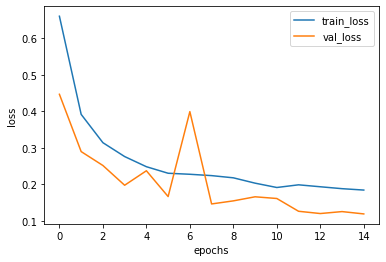

In [14]:
#（10）获取训练信息
history_dict = history.history  # 获取训练的数据字典
train_loss = history_dict['loss']  # 训练集损失
val_loss = history_dict['val_loss']  # 验证集损失
 
#（11）绘制训练损失和验证损失
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')  # 训练集损失
plt.plot(range(epochs), val_loss, label='val_loss')  # 验证集损失
plt.legend()  # 显示标签
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### 预测
为了绘图清晰，只对测试集的前200组特征（每一组有720行10列，720代表一个滑窗大小，10代表特征列个数）进行预测，使用.predict()函数 得到每组对应下一时刻的气温预测值。

7/7 [==============================] - 1s 63ms/step


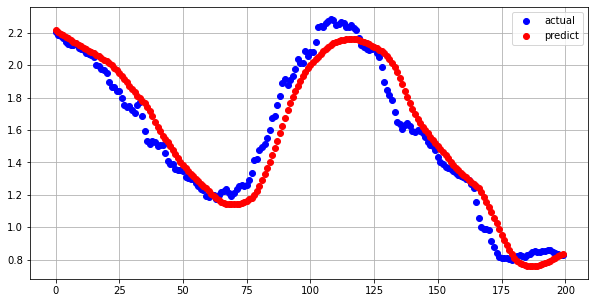

In [15]:
#（12）预测阶段
# x_test[0].shape = (720,10)
x_predict = x_test[:200]  # 用测试集的前200组特征数据来预测 
y_true = y_test[:200]  # 每组特征对应的标签值
 
y_predict = model.predict(x_predict)  # 对测试集的特征预测
 
# 绘制标准化后的气温曲线图
fig = plt.figure(figsize=(10,5))  # 画板大小
axes = fig.add_subplot(111)  # 画板上添加一张图
# 真实值, date_test是对应的时间
axes.plot(y_true, 'bo', label='actual')
# 预测值，红色散点
axes.plot(y_predict, 'ro', label='predict')
 
plt.legend()  # 注释
plt.grid()  # 网格
plt.show()